# Solar

In [21]:
#|code-fold: true
#|output: false
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import matplotlib.ticker as ticker

import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import platform
from PIL import Image
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize
import ipyplot

from step_by_step import StepByStep, InverseNormalize, load_tensor, get_means_and_stdevs 
from categorize import check_for_missing_files
from models import Segnet
plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We have accumulated labels in the `data\all_labels` folder. We need to:
- load all of them into NCWH tensors
- split them into train and valid (test labels will be separate), 
- create temporary Datasets and normalizer
- create real Datasets and DataLoaders. 

# Data processing

## Generate tensors

Let's first create a `x_tensor/y_tensor` from all_labels:

In [22]:
proj_dir = Path('.').resolve().parent
data_dir = proj_dir / 'data'
train_imgs_dir = data_dir / 'all_labels/train/imgs'
train_masks_dir = data_dir / 'all_labels/train/masks'
image_paths = sorted(list(train_imgs_dir.glob('*.png')))
mask_paths = sorted(list(train_masks_dir.glob('*.png')))
check_for_missing_files(image_paths, mask_paths)

There are {{len(image_paths)}} images.


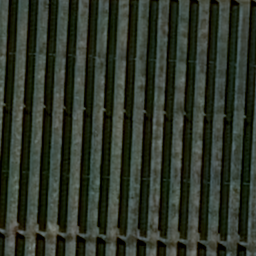
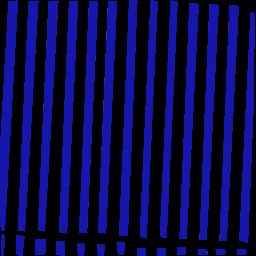


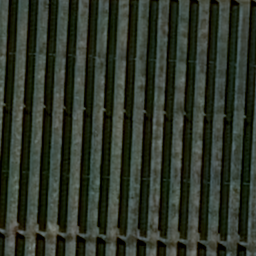
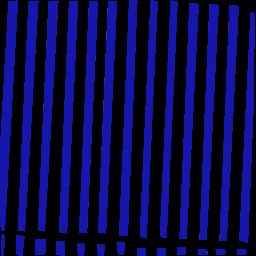

In [24]:
idx = 60
im = Image.open(image_paths[idx]).convert('RGB')
mask = Image.open(mask_paths[idx]).convert('RGB')
ipyplot.plot_images([im, mask])

For the mask, we'll use multi-class labeling:
- class 0: background, 
- class 1 (red): racks
- class 2 (green): posts
- class 3 (blue): solar panels

In [17]:
title_mapping = {0: 'background', 1: 'racks', 2: 'posts', 3: 'panels'}


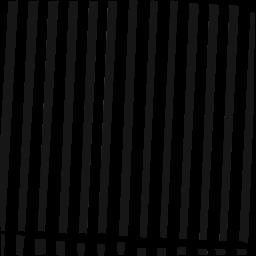
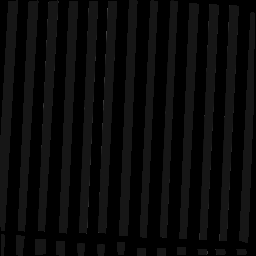
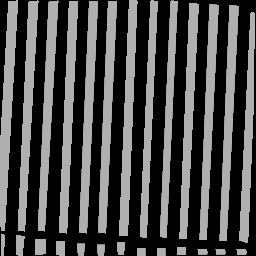


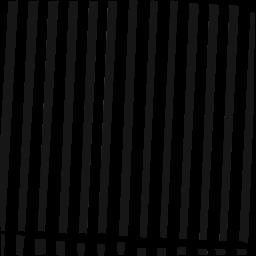
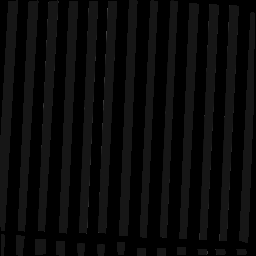
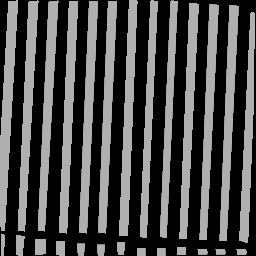

In [18]:
ipyplot.plot_images([mask.getchannel('R'), 
                     mask.getchannel('G'),
                     mask.getchannel('B')])

Let's come up with the RGB mask conversion to class (i.e. post/rack/panel):

In [19]:
def mask_transform(mask):
    """
    Takes a file (a 3D mask) finds if it is post, rack, or solar panel, and generates a (1,256,256) tensor. 
    - class 0: background, 
    - class 1 (red): racks
    - class 2 (green): posts
    - class 3 (blue): panels
    
    First we extracts the mask class_id, basically most prevalent color, can be 0(red), 1(green), or 2(blue)
    Then we take only that color channel, convert it to class. 
    """
    x = ToTensor()(mask.convert('RGB'))
    # this extracts the mask class_id, basically most prevalent color, can be 0(red), 1(green), or 2(blue)
    class_id = int(x.flatten(1,2).max(axis=1).values.argmax())
    # takes only that color channel and multiplies with class_id + 1 
    x = (x[class_id, :, :] > 0) * (class_id + 1)
    return x

In [20]:
x_tensor = load_tensor(image_paths, n_channels=3, transform=lambda x: ToTensor()(x.convert('RGB')))
y_tensor = load_tensor(mask_paths, n_channels=1, transform=mask_transform, squeeze=True).long()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 374.34it/s]


Note that for `y_tensor` we set `squeeze=True` to get rid of the channel dimension as required by `CrossEntropyLoss`.
Also note that we convert `y_tensor` to long (also required by `CrossEntropyLoss`). 

An example:

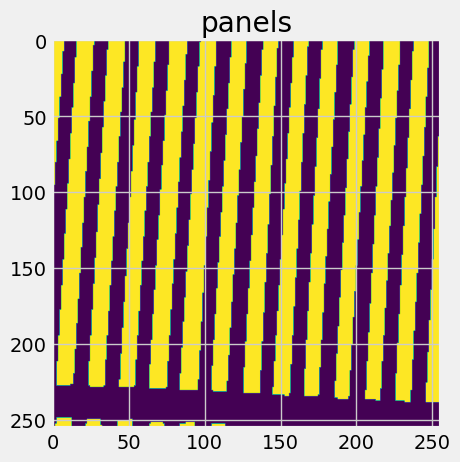

In [8]:
mask_to_show = np.array(y_tensor[idx,:,:], dtype='uint8')  # convert to numpy
plt.imshow(mask_to_show)
plt.title(f'{title_mapping[mask_to_show.max()]}')
plt.show()

In [9]:
print(x_tensor.shape)
print(y_tensor.shape)
print(x_tensor.dtype)
print(y_tensor.dtype)

torch.Size([212, 3, 256, 256])
torch.Size([212, 256, 256])
torch.float32
torch.int64


## Split into train and valid

We'll use `torch.utils.data.random_split`:

In [17]:
torch.manual_seed(13)  # Important for consistency
N = len(x_tensor)
n_train = int(.8*N)
n_val = N - n_train
train_subset, val_subset = random_split(x_tensor, [n_train, n_val])

train_idx = train_subset.indices
val_idx = val_subset.indices

print(len(train_idx))
print(len(val_idx))

169
43


In [18]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

In [19]:
print(x_train_tensor.shape)
print(y_train_tensor.shape)
print(x_val_tensor.shape)
print(y_val_tensor.shape)

torch.Size([169, 3, 256, 256])
torch.Size([169, 256, 256])
torch.Size([43, 3, 256, 256])
torch.Size([43, 256, 256])


**NOTE, it is very important that y_tensor is of shape (N, d1, d2)**

Since this is unbalanced dataset, we find contributions for each class:

In [20]:
n_classes = 4
contributions = [(y_train_tensor == i).float().sum() / np.prod(y_train_tensor.shape) for i in range(n_classes)]
# TODO convert contributions to weights
weights  = torch.Tensor([0.32, 0.01, 0.01, 0.68])
weights

tensor([0.3200, 0.0100, 0.0100, 0.6800])

## Temporary Datasets

Our very simple dataset with transform:

In [21]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

Let's first create **temporary** `Dataset` to extract normalization parameters:

In [22]:
temp_train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor)
temp_train_loader = DataLoader(temp_train_dataset, batch_size=32)
normalizer = StepByStep.make_normalizer(temp_train_loader)
normalizer

Normalize(mean=tensor([0.2003, 0.2140, 0.1656]), std=tensor([0.1067, 0.1071, 0.1084]))

## Real Datasets and Loaders

Let's now create **real** `Datasets` and `DataLoaders`:

In [23]:
train_composer = Compose([normalizer])  # train_composer will have augmentations later
val_composer = Compose([normalizer])

train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Training prep

Let's now define model, optimizer, and loss.

## Model

In [24]:
segnet = Segnet(n_channels=3, n_classes=4)
x, y = next(iter(train_loader))
segnet.eval()  # sets the mode
yhat = segnet(x)
yhat.shape

torch.Size([32, 4, 256, 256])

Cool, it checks out (we got 4 classes out).  

# Predictions from logits

For predictions we'll simply get the `argmax` accross class dimension (axis=1) (no need to convert to probabilities via `Softmax` since the results will be the same):

In [25]:
predictions_argmax = yhat.argmax(1)  # accross all classes, i.e. 1st dimension

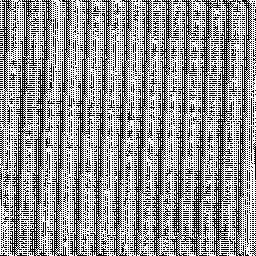

In [26]:
b = predictions_argmax[0,:,:].float()  # convert Tensor to PIL
ToPILImage()(b)

While the predictions are not great after one epoch only, we are starting to notice the shape of the solar panels already.

## Visualization

The original image looks like:

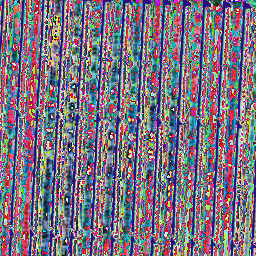

In [27]:
ToPILImage()(x[0,:,:,:])

and this looks weird since image was already normalized. Just for ploting, we can unnormalize it:

In [28]:
inv_normalizer = InverseNormalize(normalizer)

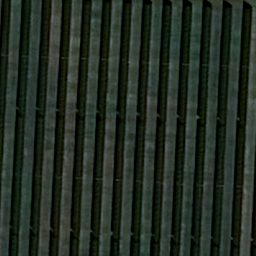

In [29]:
ToPILImage()(inv_normalizer(x[0,:,:,:]))

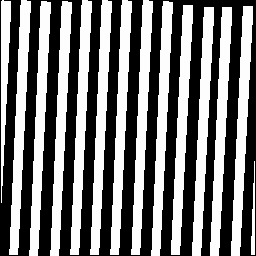

In [30]:
ToPILImage()(y[0,:,:].float())

## Optimizer and Loss

Let's define optimizer:

In [31]:
optimizer = optim.Adam(segnet.parameters(), lr=3e-4)

Let's do the mock loss evaluation:

In [32]:
yhat.shape

torch.Size([32, 4, 256, 256])

In [33]:
y.shape

torch.Size([32, 256, 256])

In [34]:
nn.CrossEntropyLoss(weight=weights)(yhat, y)

tensor(1.4200, grad_fn=<NllLoss2DBackward0>)

In [10]:
def multi_loss_fn(y_pred, y_true):
    # TODO 1) try also different losses, from https://deeplearning.berlin/satellite%20imagery/computer%20vision/fastai/2021/02/17/Building-Detection-SpaceNet7.html
    # CrossEntropyLossFlat(axis=1)
    
    out_of_bounds = (y_true == -1) # find out the out-of-bounds
    # replace out-of-bounds pixels with zeros
    return nn.CrossEntropyLoss()(y_pred.masked_fill(out_of_bounds.unsqueeze(axis=1), 0), 
                                 y_true.masked_fill(out_of_bounds, 0))

    # return nn.CrossEntropyLoss()(y_pred, y_true)  # default


In [38]:
torch.manual_seed(17)
sbs = StepByStep(segnet, optimizer, multi_loss_fn)
sbs.set_loaders(train_loader, val_loader)

# Training

In [41]:
sbs.train(20)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [12:13<00:00, 36.69s/it]


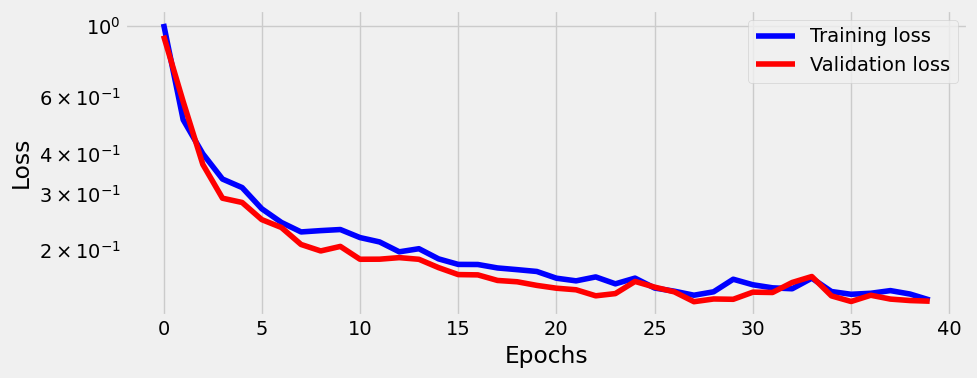

In [42]:
_ = sbs.plot_losses()

Let's visualize some of the predictions for `val_loader`:

In [43]:
val_loader_iter = iter(val_loader)

In [44]:
x_val, y_val = next(val_loader_iter)

In [45]:
def convert_class_mask_to_rgb_image(im):
    b = np.zeros([256,256, 3], dtype='uint8')
    for class_id in range(3):
        b[:,:,class_id] = np.array((im == (class_id+1))*255, dtype='uint8')
    return b
        
def display_images(x_batch, y_batch, show_original=False, normalizer=None, idx_map=None, idx_offset=0):
    if show_original:
        inv_normalizer = InverseNormalize(normalizer)
    
    if len(x_batch) > 64:
        raise Warning(f"There are {len(x_batch)} images to show, I set the limit to 64.")
        return
    
    y_pred_batch = sbs.predict(x_batch)
    
    for idx in range(len(x_batch)):
        # convert to PIL images
        
        img_a = Image.fromarray(convert_class_mask_to_rgb_image(y_pred_batch.argmax(1)[idx,:,:]))
        img_b = ToPILImage()(y_batch[idx,:,:].float())
        if show_original:
            img_c = ToPILImage()(inv_normalizer(x_batch[idx,:,:,:]))
        
        N = 3 if show_original else 2
        fig, ax = plt.subplots(1,N)
        ax[0].imshow(img_a)
        ax[0].set_title(f"{idx_offset + idx} - {'' if not idx_map else idx_map[idx_offset + idx]}")
        ax[1].imshow(img_b)
        if show_original: 
            ax[2].imshow(img_c)
        for i in range(N):
            ax[i].grid(False)
            ax[i].xaxis.set_major_locator(ticker.NullLocator())
            ax[i].yaxis.set_major_locator(ticker.NullLocator())
        plt.show()

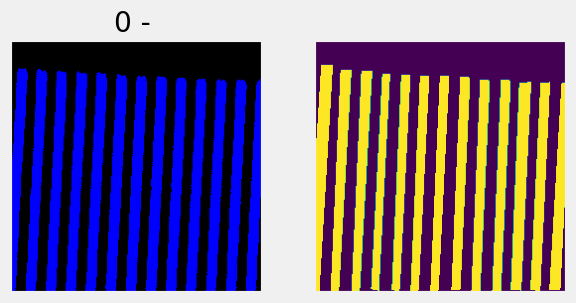

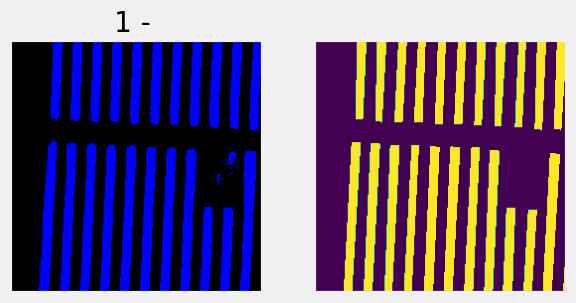

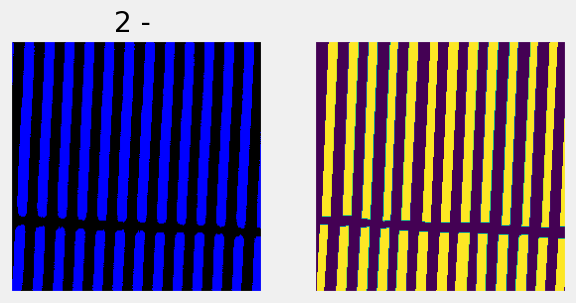

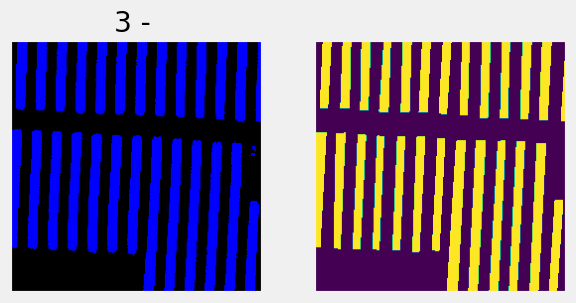

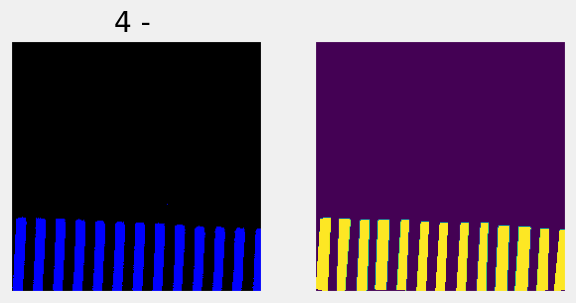

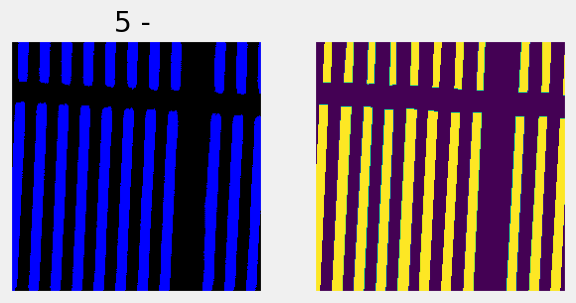

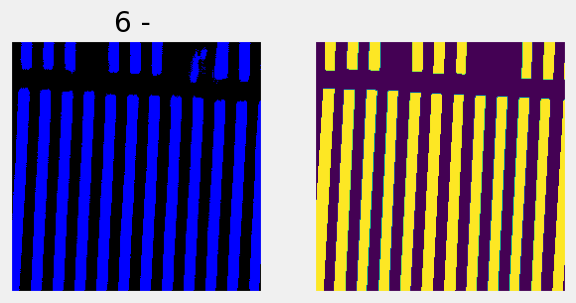

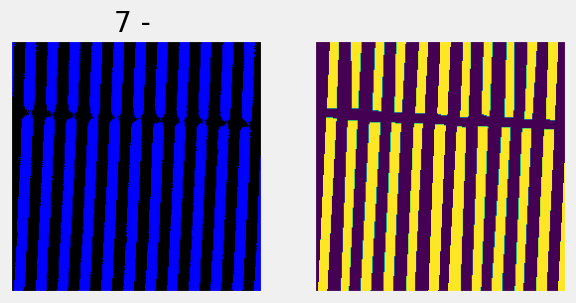

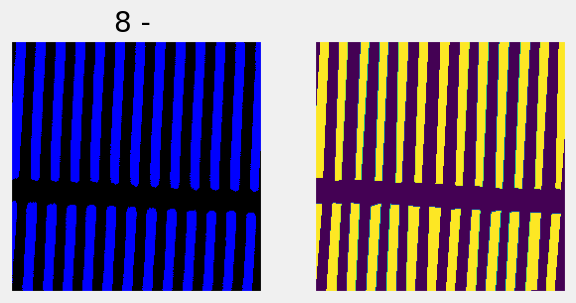

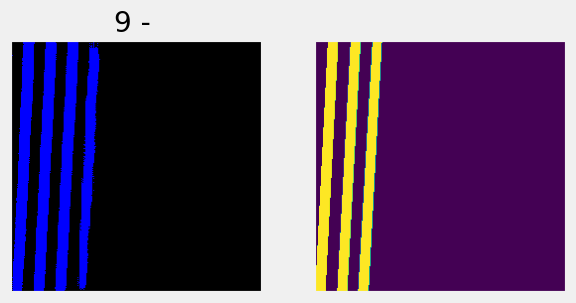

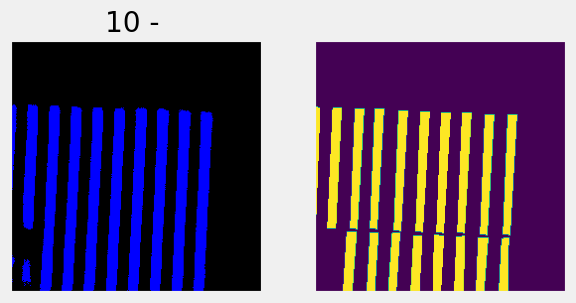

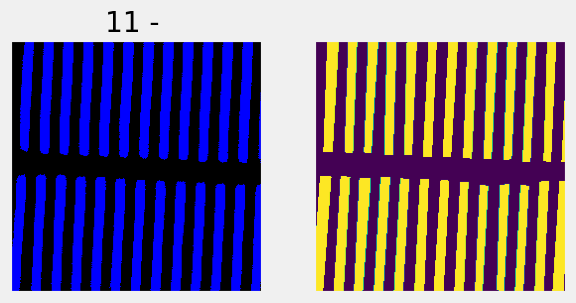

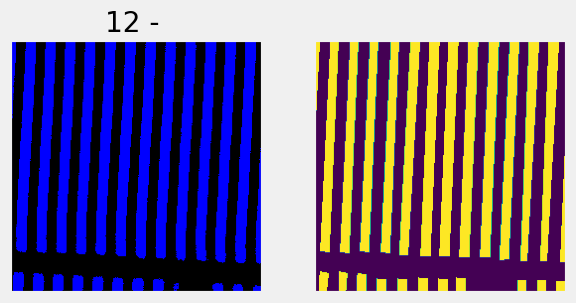

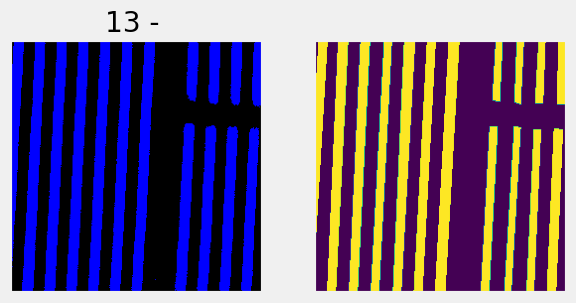

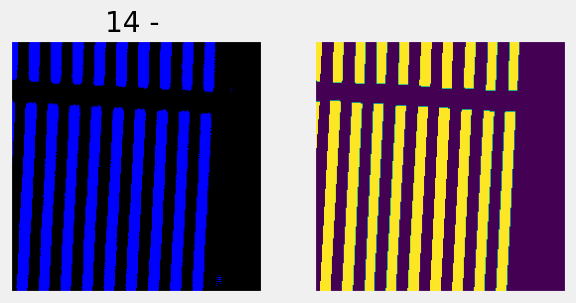

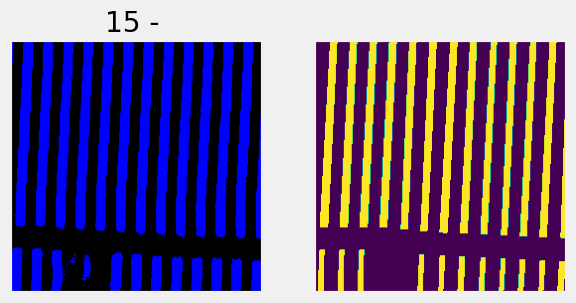

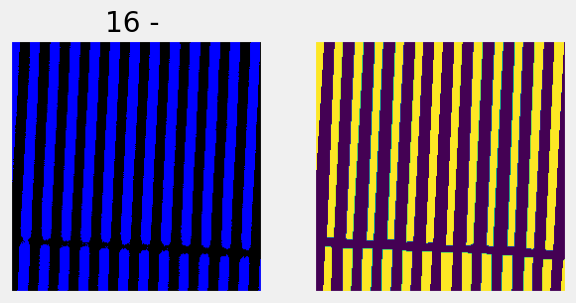

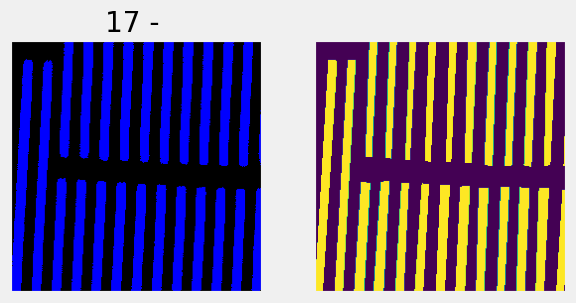

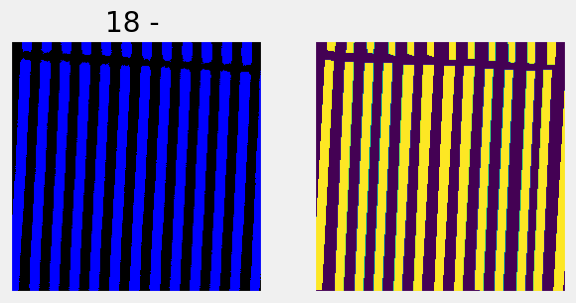

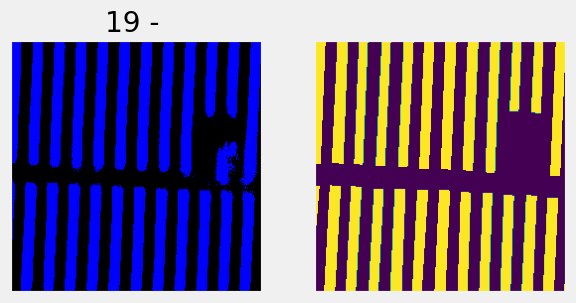

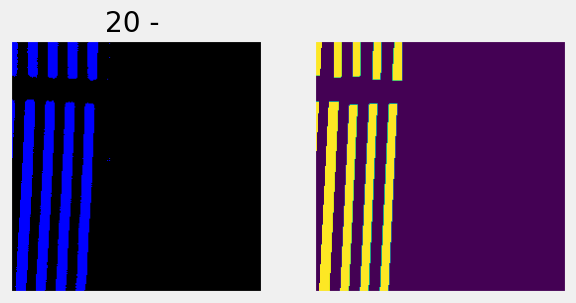

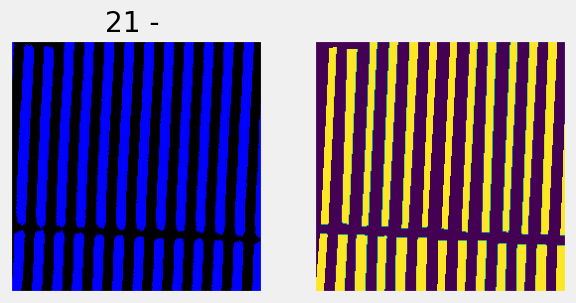

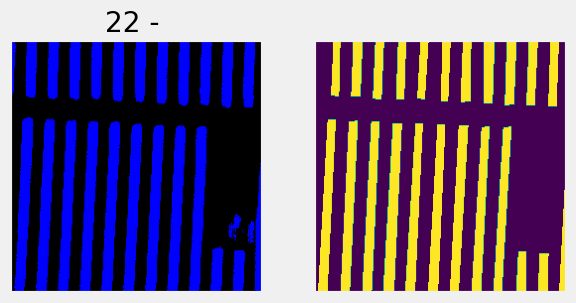

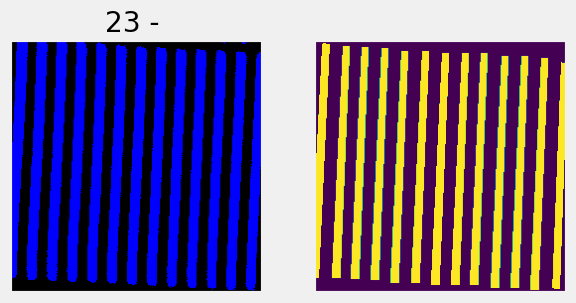

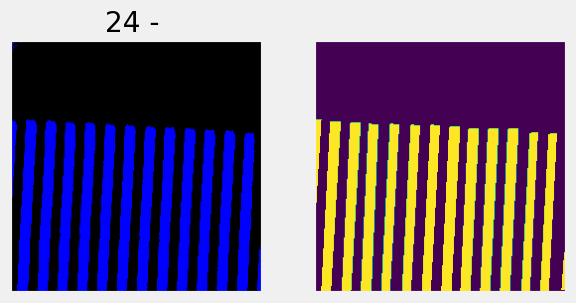

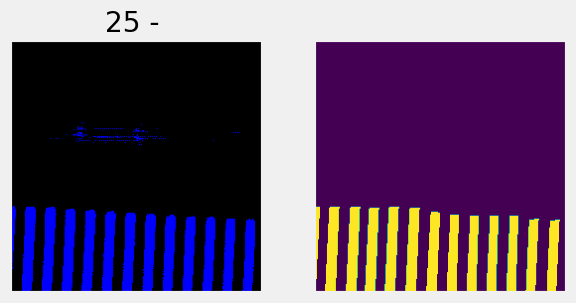

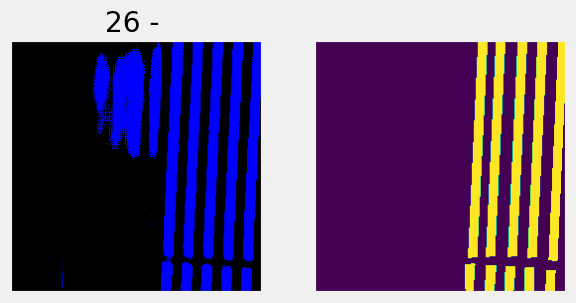

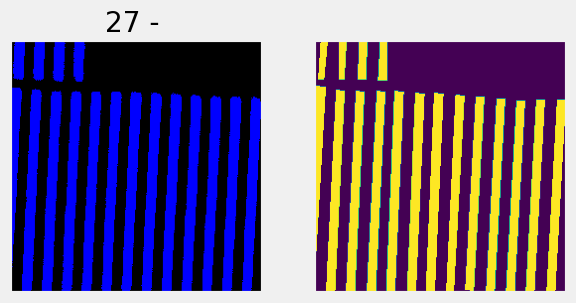

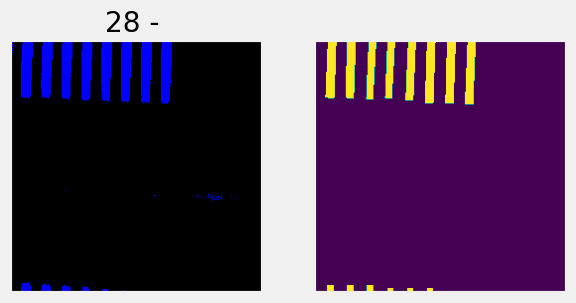

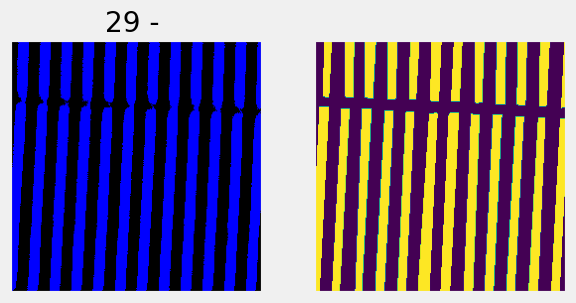

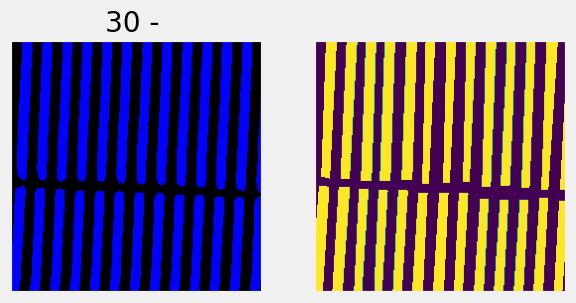

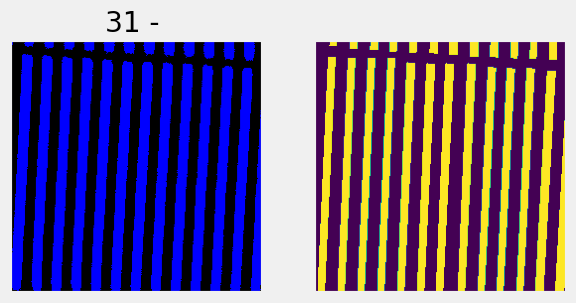

In [46]:
display_images(x_val, y_val)

This is a very good start. 

Let's save the model:

In [47]:
sbs.save_checkpoint('2022_01_09_multi_class_segnet.tar')

to load the model reinitialize the sbs (with model, optimizer, and loss), then run:

In [48]:
# sbs.load_checkpoint('2022_01_04_segnet.tar')

# Evaluation

## Evaluation dataset

Let's evaluate the model on unseen images. First we'll generate an `x_eval_tensor`:

In [49]:
eval_imgs_dir = data_dir / '6126758101/IMG_PHR1B_PMS-N_001/cropped'
eval_image_paths = sorted(list(eval_imgs_dir.glob('*.png')))

In [50]:
len(eval_image_paths)

6555

In [51]:
x_eval_tensor = load_tensor(eval_image_paths, n_channels=3, transform=lambda x: ToTensor()(x.convert('RGB')))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6555/6555 [00:27<00:00, 235.81it/s]


In [52]:
idx_map = {i: image_path.name for i, image_path in enumerate(eval_image_paths)}

In [53]:
x_eval_tensor.shape

torch.Size([6555, 3, 256, 256])

In [54]:
x_eval_tensor_size = x_eval_tensor.element_size() * x_eval_tensor.nelement() / (10**9)

The `x_eval_tensor` is {{x_eval_tensor_size}} Gb.

We don't have label's yet so we create a mock y_eval_tensor:

In [55]:
y_eval_tensor = torch.zeros_like(x_eval_tensor)

In [56]:
y_eval_tensor.shape

torch.Size([6555, 3, 256, 256])

Next we create a dataset, we'll reuse `val_composer` since it contains only normalization:

In [61]:
eval_dataset = TransformedTensorDataset(x_eval_tensor, y_eval_tensor, transform=val_composer)
batch_size = 32
eval_loader = DataLoader(eval_dataset, batch_size=batch_size)
eval_loader_iter = iter(eval_loader)
batch_idx = -1

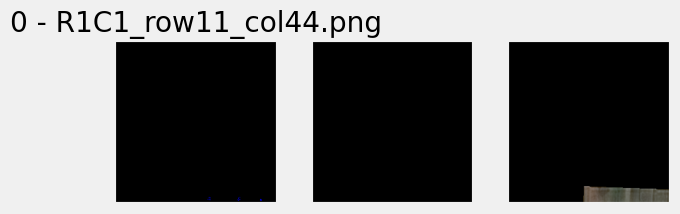

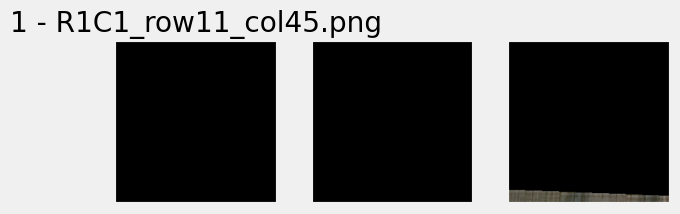

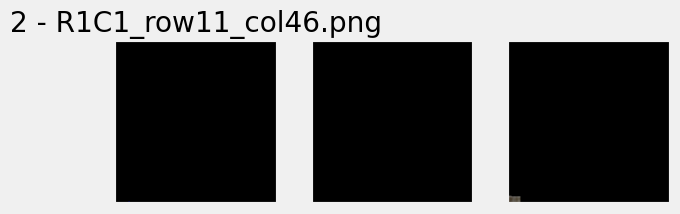

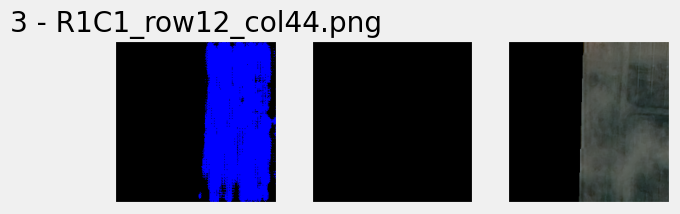

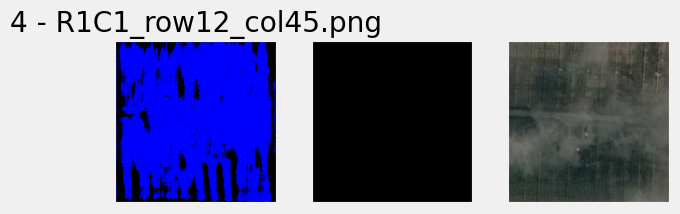

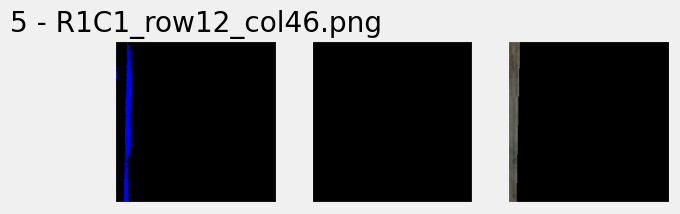

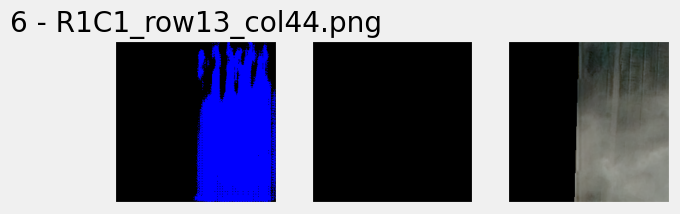

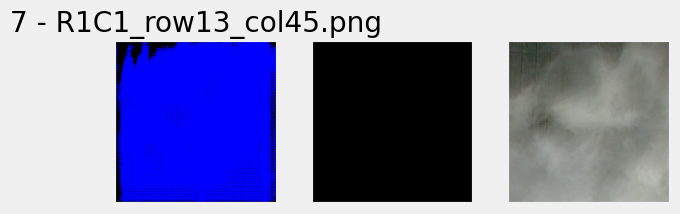

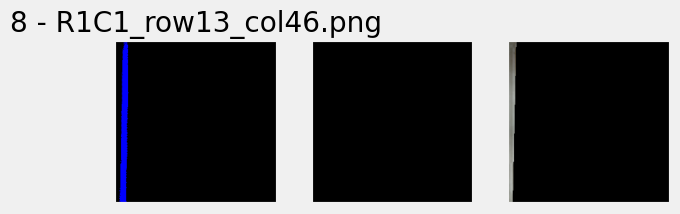

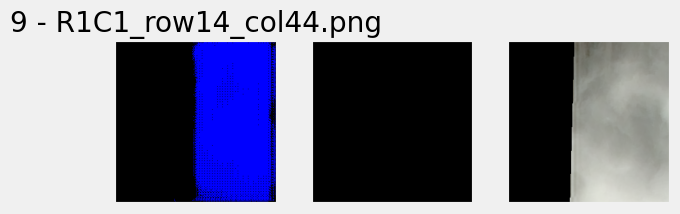

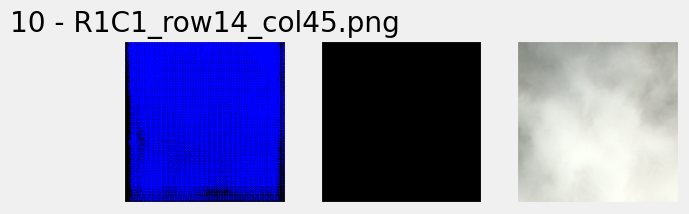

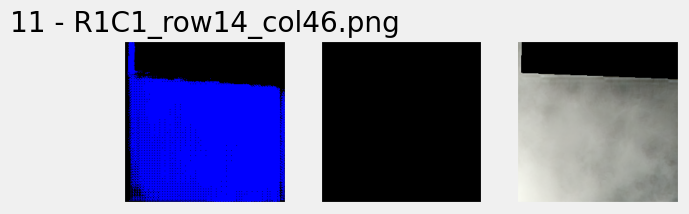

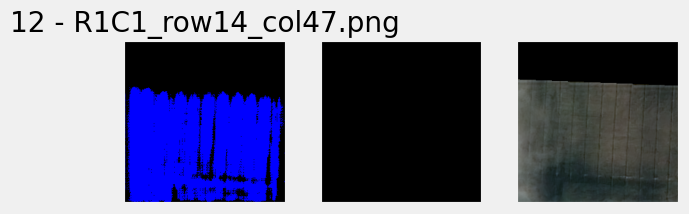

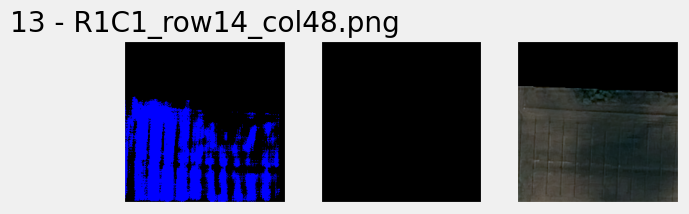

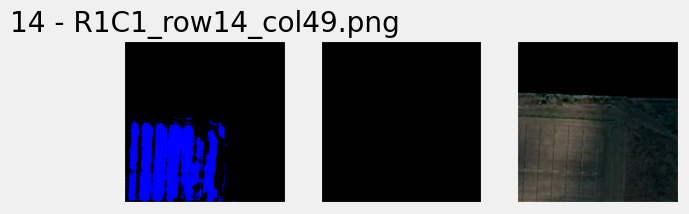

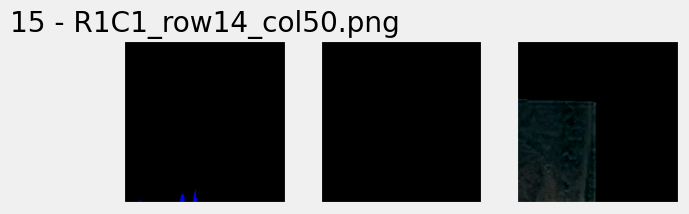

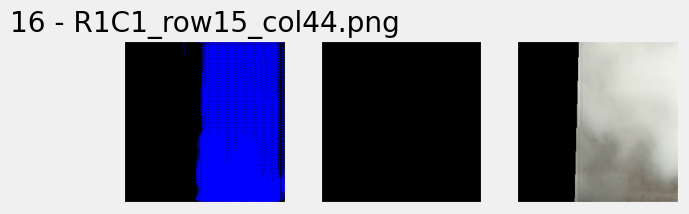

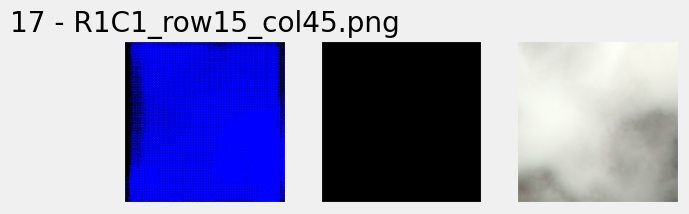

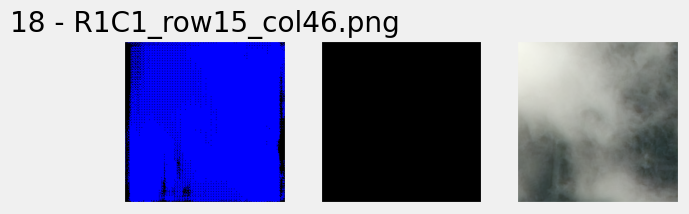

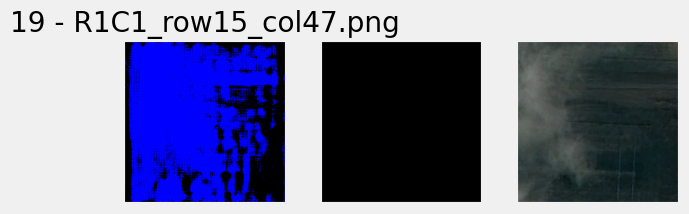

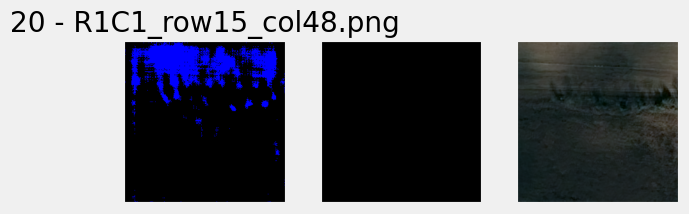

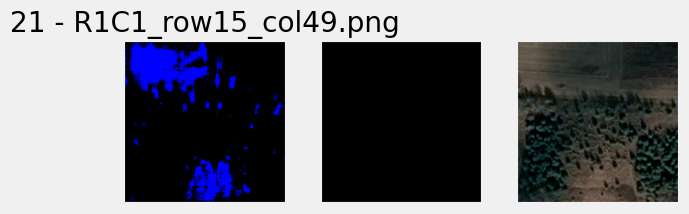

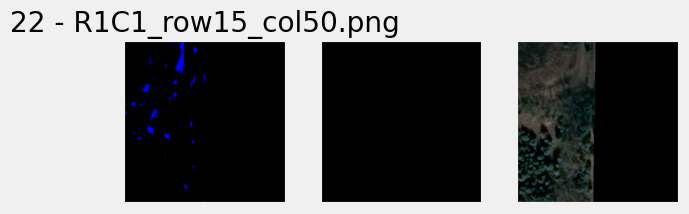

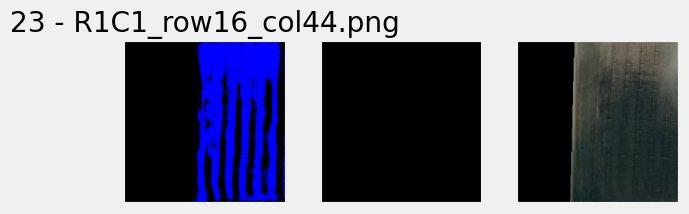

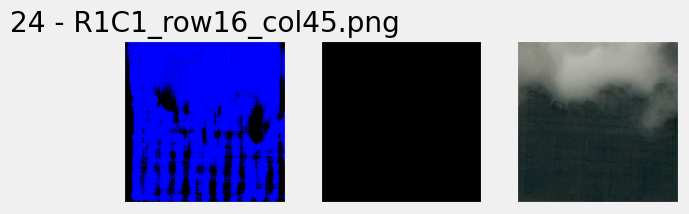

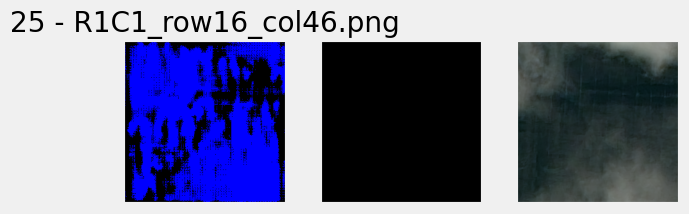

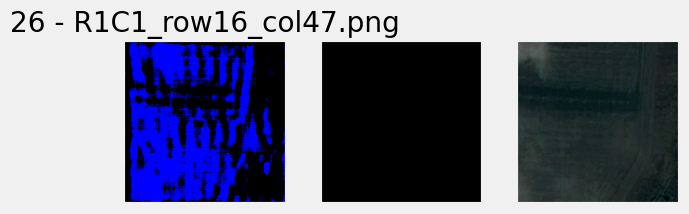

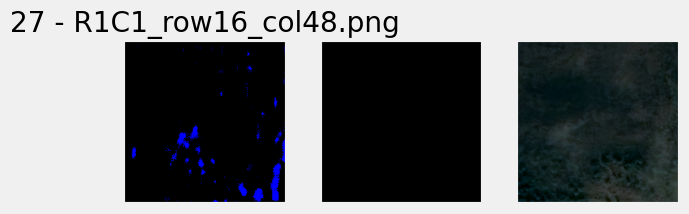

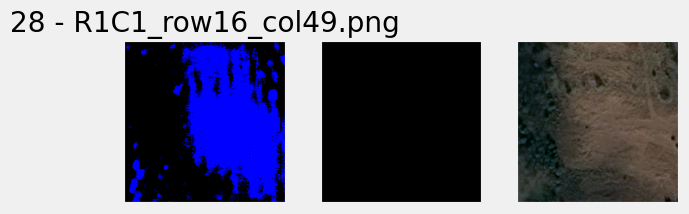

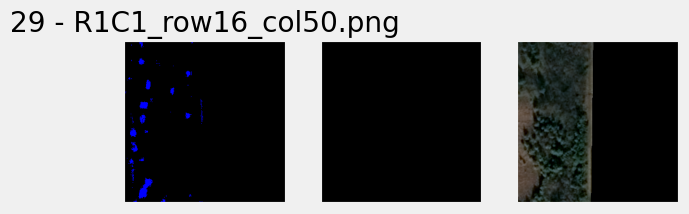

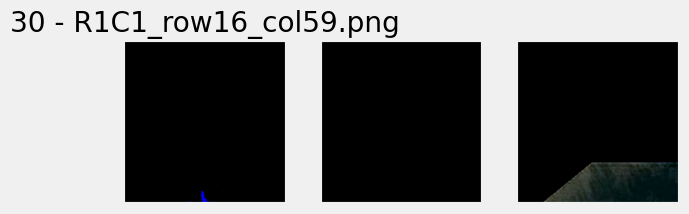

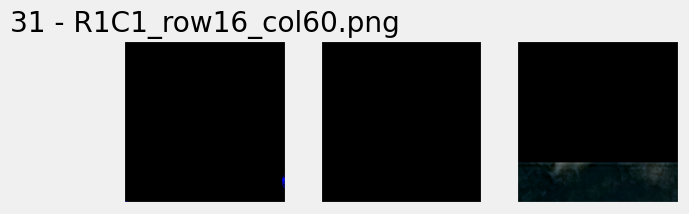

In [62]:
(x_eval, y_eval), batch_idx = next(eval_loader_iter), batch_idx + 1 
display_images(x_eval, y_eval, True, normalizer, idx_map, batch_idx*batch_size)

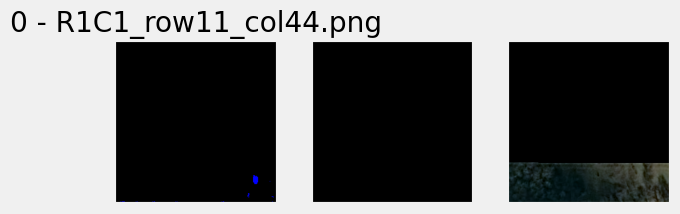

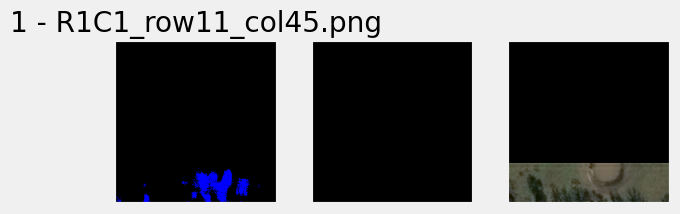

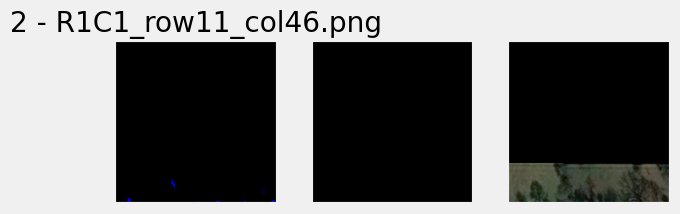

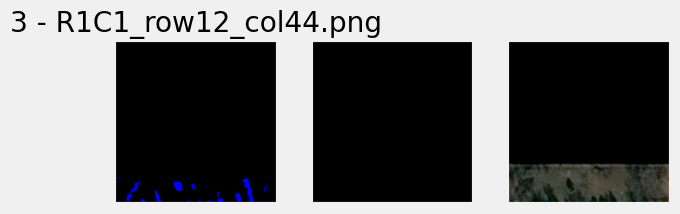

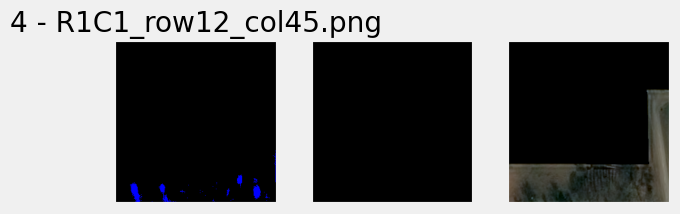

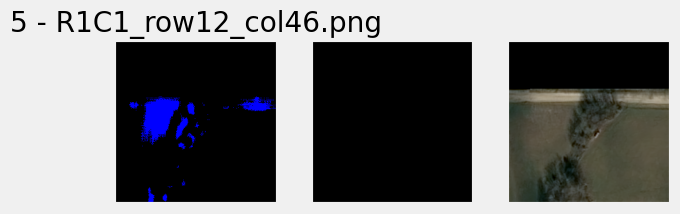

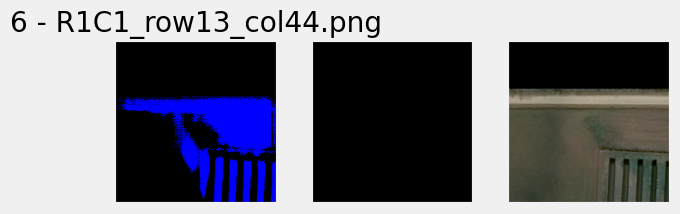

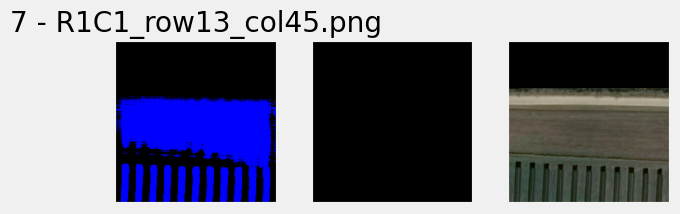

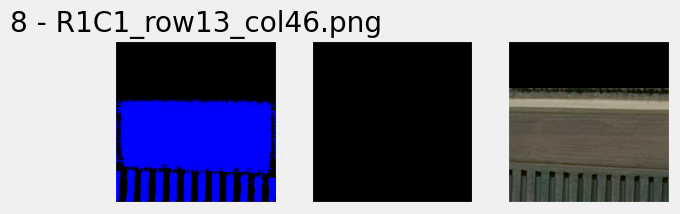

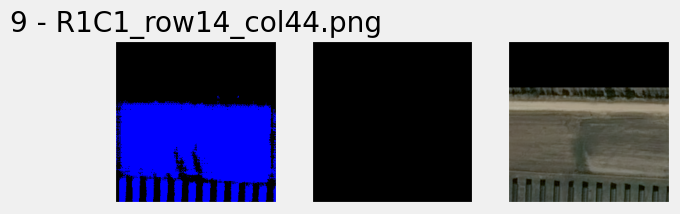

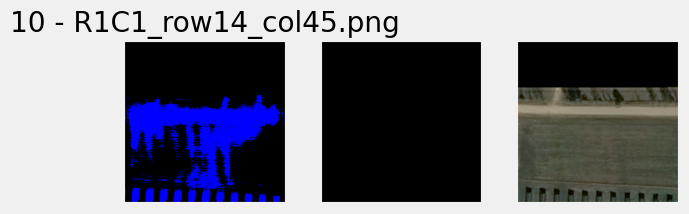

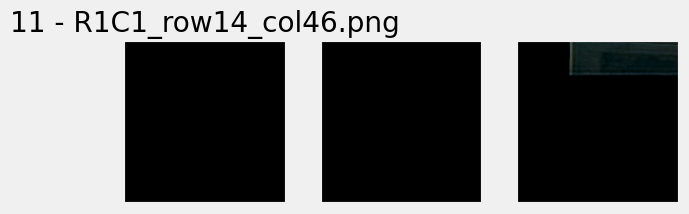

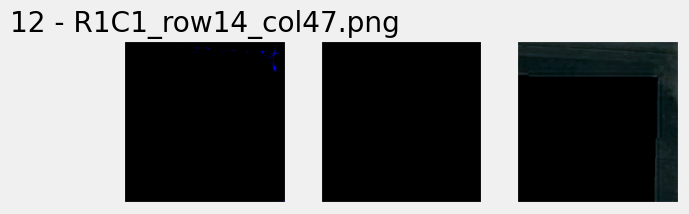

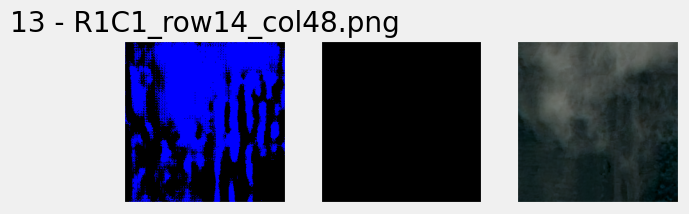

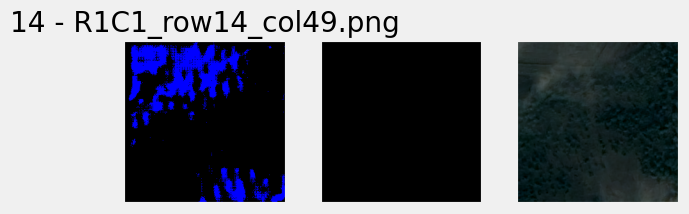

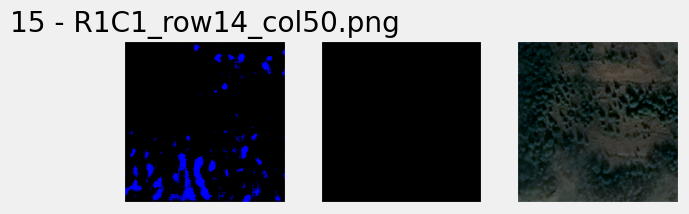

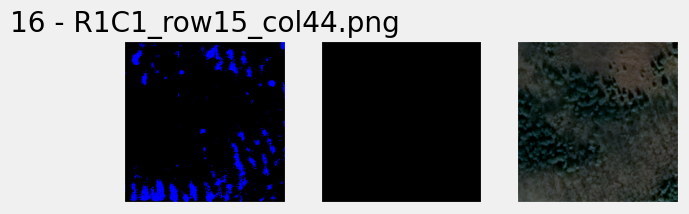

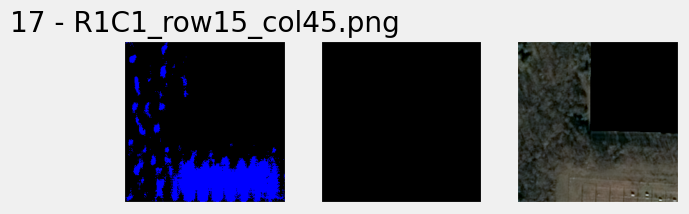

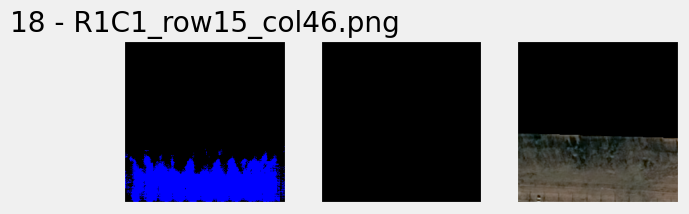

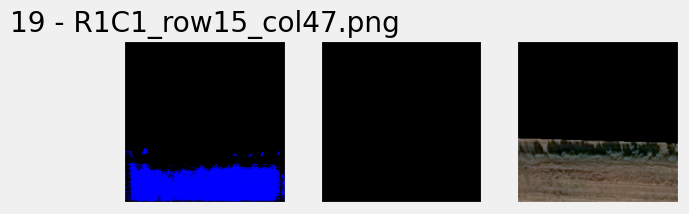

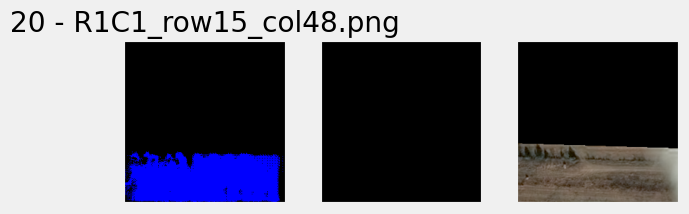

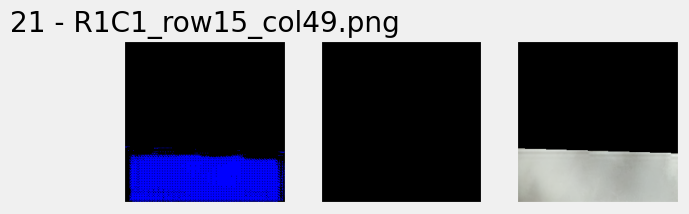

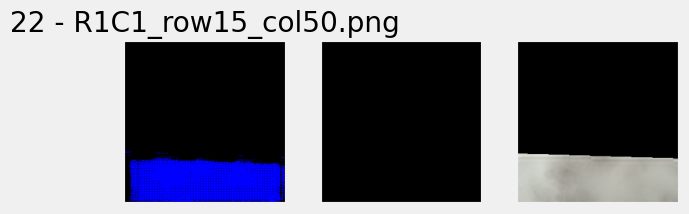

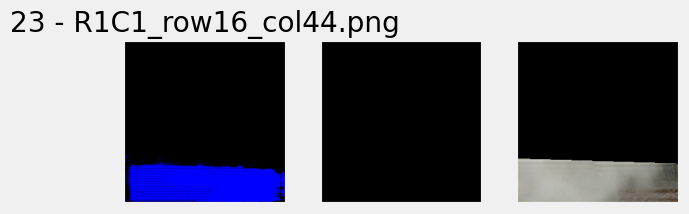

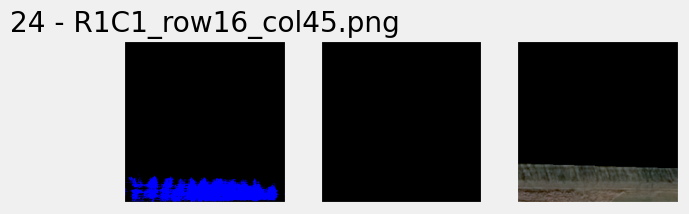

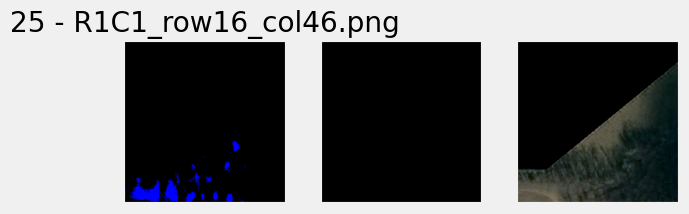

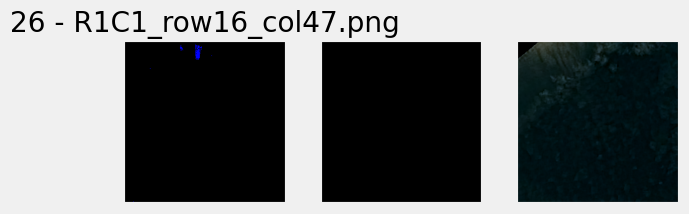

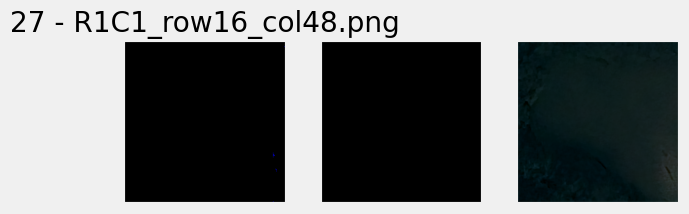

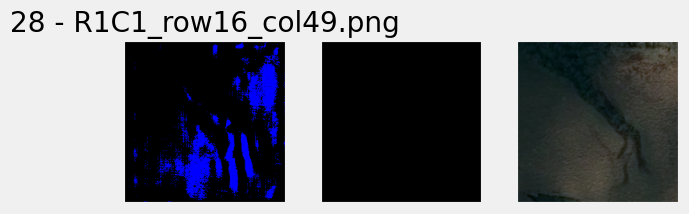

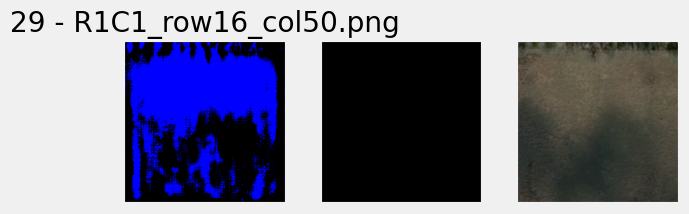

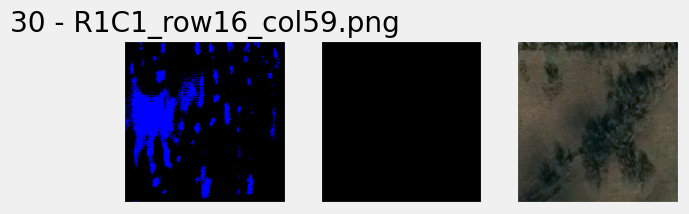

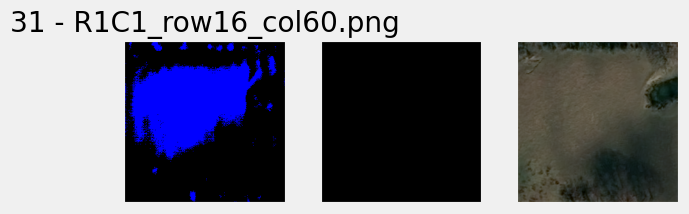

In [58]:
x_eval, y_eval = next(eval_loader_iter)
display_images(x_eval, y_eval, True, normalizer, idx_map, idx_offset)

So clearly some of the solar panels are detected, but now nearly as good as in validation set. This means our training and validation sets are not representing the whole eval set. Furthermore, there are lot's of false positives. We need to do the following:
- augmentation
- adding more solar-panel images to the training dataset
- adding non-solar-panels images to the training dataset.

## mean/stdev plots

To see the range of mean and stdev accross `train` and `eval` datasets, let's look into mean and stdev for **individial** images, i.e. mean and stdev accross channels for all training and eval images **before** normalization. A straightforward way to do this is by using `x_train_tensor` and `x_eval_tensor`:

In [155]:
def plot_means_and_stdevs(train_means, train_stdevs, eval_means, eval_stdevs):
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    for i in range(3):
        axs[i].plot(eval_means[:,i], eval_stdevs[:,i], '.')
        axs[i].plot(train_means[:,i], train_stdevs[:,i], '.')
        axs[i].set_xlabel('means')
        axs[i].set_ylabel('stdev')
        axs[i].set_title(f'Channel #{i+1}')
        axs[i].legend(['eval', 'train'])
    plt.show()

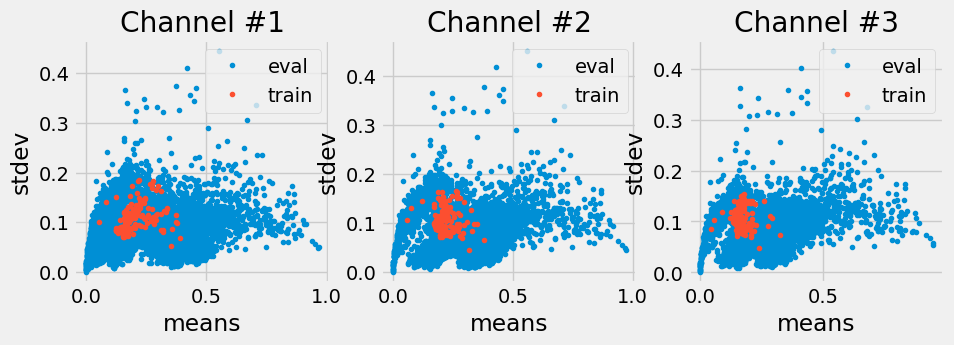

In [156]:
train_means, train_stdevs = get_means_and_stdevs(x_train_tensor)
eval_means, eval_stdevs = get_means_and_stdevs(x_eval_tensor)
plot_means_and_stdevs(train_means, train_stdevs, eval_means, eval_stdevs)

So we see that train dataset is not covering all the cases, far from it. 

Let's now plot a similar versions using `normalizer`:

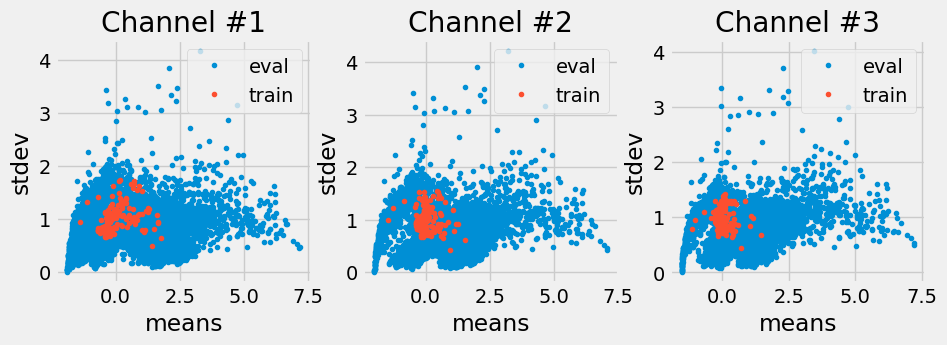

In [157]:
train_means, train_stdevs = get_means_and_stdevs(normalizer(x_train_tensor))
eval_means, eval_stdevs = get_means_and_stdevs(normalizer(x_eval_tensor))
plot_means_and_stdevs(train_means, train_stdevs, eval_means, eval_stdevs)

and we see that `train` dataset has mean/stdev at 0/1, but that's not nearly the case for `eval` dataset.

# Generate new labels

We need to come up with the metric on how good are we doing. Clearly, validation set is not good enough, so we need new labels. Let's first come up with the list of 20 images to label for start. This is easier done outside Jupyter:

In [ ]:
eval_dataset = TransformedTensorDataset(x_eval_tensor, y_eval_tensor, transform=val_composer)
batch_size = 32
eval_loader = DataLoader(eval_dataset, batch_size=batch_size)
eval_loader_iter = iter(eval_loader)
batch_idx = -1

In [ ]:
(x_eval, y_eval), batch_idx = next(eval_loader_iter), batch_idx + 1 
display_images(x_eval, y_eval, True, normalizer, idx_map, batch_idx*batch_size)

## Dice coeficient


[Dice](https://docs.fast.ai/metrics.html) coefficient quantifies our model ...  

## Augmentation

Let's create a new composer, then 

## Adding non-solar-panel training images

In [ ]:
## Adding solar-pane